In [1]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

In [2]:
from datetime import datetime
import pandas as pd
import requests


def convertTimeStampToUTC(data):
    
    return datetime.fromtimestamp(data)
  
def getURL(apiKey, cryptoSymbol, frequency, timestamp, maxRecords):
    
    API_KEY = '&api_key=' + str(apiKey)
    limit = '&limit=' + str(maxRecords)
    header = 'fsym=' + str(cryptoSymbol)
    currency = '&tsym=USD'

    if (timestamp == ""):
        url = 'https://min-api.cryptocompare.com/data/v2/histo' + frequency + '?' + header
    
    else:  
        url = 'https://min-api.cryptocompare.com/data/v2/histo' + frequency + '?' + header + '&toTs=' + str(timestamp)

    return url + currency + API_KEY + limit  


def getCryptoData(apiKey, crypto, frequency, numOfRequests, maxRecords):
    
    numOfRequests = 5
    data = pd.DataFrame()
    nextTimeStamp = 0

    for i in range(0, numOfRequests):
        if (nextTimeStamp == 0):
            url = getURL(apiKey, crypto, frequency, "", maxRecords)
    
        else:
            url = getURL(apiKey, crypto, frequency, nextTimeStamp, maxRecords)

        response = requests.get(url).json()
        partialData = pd.DataFrame(response.get('Data').get('Data'))
        nextTimeStamp = partialData['time'].min() - 1
        data = pd.concat([data, partialData])

    data = data.sort_values(by = ['time'],ignore_index = True)
    data['timeUTC'] = data['time'].apply(convertTimeStampToUTC)
    data = data.reset_index(drop = True)
    return data

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers

data = pd.read_csv('bitcoin2000.csv')
data1 = data.set_index(pd.DatetimeIndex(data['timeUTC']))[['close']]
data2=data.set_index(pd.DatetimeIndex(data['timeUTC']))[['open']]
data3=data.set_index(pd.DatetimeIndex(data['timeUTC']))[['close','open','low','high']]

In [4]:
data3

,close,open,low,high
timeUTC,,,,
2019-12-12 19:00:00,7166.14,7170.18,7149.15,7219.93
2019-12-12 20:00:00,7199.79,7166.14,7166.03,7208.36
2019-12-12 21:00:00,7199.97,7199.79,7194.87,7222.43
2019-12-12 22:00:00,7201.38,7199.97,7187.29,7211.80
2019-12-12 23:00:00,7173.50,7201.38,7152.84,7229.22
...,...,...,...,...
2021-02-01 11:00:00,33675.45,33450.01,33257.39,33847.46
2021-02-01 12:00:00,33590.20,33675.45,33505.50,33779.76
2021-02-01 13:00:00,33576.82,33590.20,33404.87,33945.41


In [5]:
data1

,close
timeUTC,
2019-12-12 19:00:00,7166.14
2019-12-12 20:00:00,7199.79
2019-12-12 21:00:00,7199.97
2019-12-12 22:00:00,7201.38
2019-12-12 23:00:00,7173.50
...,...
2021-02-01 11:00:00,33675.45
2021-02-01 12:00:00,33590.20
2021-02-01 13:00:00,33576.82


In [111]:
data3[['close','high']]

,close,high
timeUTC,,
2019-12-12 19:00:00,7166.14,7219.93
2019-12-12 20:00:00,7199.79,7208.36
2019-12-12 21:00:00,7199.97,7222.43
2019-12-12 22:00:00,7201.38,7211.80
2019-12-12 23:00:00,7173.50,7229.22
...,...,...
2021-02-01 11:00:00,33675.45,33847.46
2021-02-01 12:00:00,33590.20,33779.76
2021-02-01 13:00:00,33576.82,33945.41


In [88]:
from sklearn.preprocessing import MinMaxScaler
values = data3[['close','low','high','open']].values.reshape(-1,4)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [89]:
scaled

array([[0.07853526, 0.08642124, 0.06953334, 0.07864372],
       [0.07943861, 0.08687709, 0.06922349, 0.07853526],
       [0.07944345, 0.08765591, 0.06960029, 0.07943861],
       ...,
       [0.787544  , 0.7954491 , 0.7852376 , 0.7879032 ],
       [0.7936165 , 0.7971504 , 0.78423285, 0.787544  ],
       [0.79614097, 0.80448914, 0.7853785 , 0.7936165 ]], dtype=float32)

In [98]:
train_size = int(len(scaled) * 0.85)
val_size = len(scaled) - train_size

test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

8504 1501


In [122]:
trainX

array([[0.07853526, 0.07943861, 0.07944345, 0.07948129, 0.07873285,
        0.07950117],
       [0.07943861, 0.07944345, 0.07948129, 0.07873285, 0.07950117,
        0.07977526],
       [0.07944345, 0.07948129, 0.07873285, 0.07950117, 0.07977526,
        0.07980587],
       ...,
       [0.2969556 , 0.2913795 , 0.28947163, 0.29217225, 0.2951843 ,
        0.29748446],
       [0.2913795 , 0.28947163, 0.29217225, 0.2951843 , 0.29748446,
        0.29883933],
       [0.28947163, 0.29217225, 0.2951843 , 0.29748446, 0.29883933,
        0.29901117]], dtype=float32)

In [99]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [100]:
look_back = 6
trainX, trainY = create_dataset(train, look_back)
#valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

8498
1495


In [33]:
look_back = 24
trainX, trainY = create_dataset(train, look_back)
#valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

7980
1977


In [101]:
print(trainX.shape)
print(trainY.shape)
#print(valX.shape)
#print(valY.shape)
print(testX.shape)
print(testY.shape)


(8498, 6)
(8498,)
(1495, 6)
(1495,)


In [102]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],testX.shape[1], 1 ))

In [103]:
import tensorflow as tf
import tensorflow.keras as k
import numpy as np

batch_size =128
epochs = 100
learning_rate = 0.001
dilations = 6
seq_length=24

class TCNBlock(k.Model):
    def __init__(self, dilation, seq_length):
        super(TCNBlock, self).__init__()
        self.seq_length = seq_length

        self.convolution0 = k.layers.Conv1D(16, kernel_size=4, strides=1, padding='causal', dilation_rate=dilation)
        self.BatchNorm0 = k.layers.BatchNormalization()
        self.relu0 = k.layers.ReLU()
        self.dropout0 = k.layers.Dropout(rate=0.5)

        self.convolution1 = k.layers.Conv1D(16, kernel_size=5, strides=1, padding='causal', dilation_rate=dilation)
        self.BatchNorm1 = k.layers.BatchNormalization()
        self.relu1 = k.layers.ReLU()
        self.dropout1 = k.layers.Dropout(rate=0.5)
        self.residual = k.layers.Conv1D(1, kernel_size=1, padding='same')


    def build_block(self, dilation, training=False):
        inputs = k.Input(shape=(6, 1))
        output_layer1 = self.convolution0(inputs)
        output_layer2 = self.BatchNorm0(output_layer1)
        output_layer3 = self.relu0(output_layer2)
        output_layer4 = self.dropout0(output_layer3, training)
        output_layer5 = self.convolution1(output_layer4)
        output_layer6 = self.BatchNorm1(output_layer5)
        output_layer7 = self.relu1(output_layer6)
        
        output = self.dropout1(output_layer7, training)
        residual = self.residual(output)
        outputs = k.layers.add([inputs, residual])


        return k.models.Model(inputs=inputs, outputs=outputs)


def build_model():
    mdl = k.models.Sequential()
    for dilation in range(dilations):
        dilation_actual = int(np.power(2, dilation))
        block = TCNBlock(dilation_actual, seq_length).build_block(dilation_actual)
        mdl.add(block)
    mdl.add(MaxPooling1D(pool_size=2))
    mdl.add(Flatten())
    mdl.add(Dense(100))
    mdl.add(Dense(1))

    return mdl


Model_complete = build_model()
opt = k.optimizers.Adam(learning_rate=learning_rate)
Model_complete.compile(loss='mean_squared_error', optimizer=opt)

filepath="saved_weights/dilated2.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss',mode='min',save_best_only='True', verbose=1)

# Train Model
training_process = Model_complete.fit(trainX, trainY, epochs=epochs, verbose=1, validation_data=(testX, testY),batch_size=128, callbacks=[mc])

Train on 8498 samples, validate on 1495 samples
Epoch 1/100
8320/8498 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 00001: val_loss improved from inf to 0.46279, saving model to saved_weights/dilated2.hdf5
8498/8498 [==============================] - 4s 470us/sample - loss: 0.0068 - val_loss: 0.4628
Epoch 2/100
8320/8498 [============================>.] - ETA: 0s - loss: 7.8246e-04
Epoch 00002: val_loss did not improve from 0.46279
8498/8498 [==============================] - 1s 110us/sample - loss: 7.7450e-04 - val_loss: 0.4988
Epoch 3/100
8320/8498 [============================>.] - ETA: 0s - loss: 2.9368e-04
Epoch 00003: val_loss did not improve from 0.46279
8498/8498 [==============================] - 1s 109us/sample - loss: 2.9136e-04 - val_loss: 0.4908
Epoch 4/100
8448/8498 [============================>.] - ETA: 0s - loss: 2.0773e-04
Epoch 00004: val_loss improved from 0.46279 to 0.45951, saving model to saved_weights/dilated2.hdf5
8498/8498 [==================

8320/8498 [============================>.] - ETA: 0s - loss: 7.4536e-05
Epoch 00034: val_loss did not improve from 0.21282
8498/8498 [==============================] - 1s 111us/sample - loss: 7.3786e-05 - val_loss: 0.2847
Epoch 35/100
8320/8498 [============================>.] - ETA: 0s - loss: 8.0785e-05
Epoch 00035: val_loss did not improve from 0.21282
8498/8498 [==============================] - 1s 119us/sample - loss: 8.0142e-05 - val_loss: 0.3004
Epoch 36/100
8320/8498 [============================>.] - ETA: 0s - loss: 8.1794e-05
Epoch 00036: val_loss did not improve from 0.21282
8498/8498 [==============================] - 1s 108us/sample - loss: 8.2402e-05 - val_loss: 0.3167
Epoch 37/100
8448/8498 [============================>.] - ETA: 0s - loss: 1.0989e-04
Epoch 00037: val_loss did not improve from 0.21282
8498/8498 [==============================] - 1s 116us/sample - loss: 1.0973e-04 - val_loss: 0.2699
Epoch 38/100
8448/8498 [============================>.] - ETA: 0s - loss:

KeyboardInterrupt: 

In [157]:
training_process = model.fit(trainX, trainY, epochs=200, verbose=1, validation_data=(testX, testY),batch_size=32, callbacks=[mc])

Train on 7998 samples, validate on 1995 samples
Epoch 1/200
7904/7998 [============================>.] - ETA: 0s - loss: 2.0419e-04
Epoch 00001: val_loss improved from 0.00121 to 0.00031, saving model to saved_weights/dilated1.hdf5
7998/7998 [==============================] - 4s 554us/sample - loss: 2.0255e-04 - val_loss: 3.0522e-04
Epoch 2/200
7904/7998 [============================>.] - ETA: 0s - loss: 5.9159e-05
Epoch 00002: val_loss did not improve from 0.00031
7998/7998 [==============================] - 3s 314us/sample - loss: 5.8828e-05 - val_loss: 0.0034
Epoch 3/200
7840/7998 [============================>.] - ETA: 0s - loss: 6.7146e-05
Epoch 00003: val_loss did not improve from 0.00031
7998/7998 [==============================] - 3s 326us/sample - loss: 6.8500e-05 - val_loss: 0.0029
Epoch 4/200
7968/7998 [============================>.] - ETA: 0s - loss: 7.5084e-05
Epoch 00004: val_loss did not improve from 0.00031
7998/7998 [==============================] - 3s 317us/sample -

Epoch 35/200
7872/7998 [============================>.] - ETA: 0s - loss: 1.8858e-05
Epoch 00035: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 316us/sample - loss: 1.8886e-05 - val_loss: 0.0024
Epoch 36/200
7904/7998 [============================>.] - ETA: 0s - loss: 2.1307e-05
Epoch 00036: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 331us/sample - loss: 2.1383e-05 - val_loss: 0.0014
Epoch 37/200
7904/7998 [============================>.] - ETA: 0s - loss: 3.2576e-05
Epoch 00037: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 346us/sample - loss: 3.2456e-05 - val_loss: 0.0026
Epoch 38/200
7904/7998 [============================>.] - ETA: 0s - loss: 2.3723e-05
Epoch 00038: val_loss did not improve from 0.00018
7998/7998 [==============================] - 5s 630us/sample - loss: 2.4206e-05 - val_loss: 0.0033
Epoch 39/200
7904/7998 [============================>.] - ET

Epoch 70/200
7904/7998 [============================>.] - ETA: 0s - loss: 1.2388e-05
Epoch 00070: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 316us/sample - loss: 1.2374e-05 - val_loss: 0.0020
Epoch 71/200
7808/7998 [============================>.] - ETA: 0s - loss: 1.7430e-05
Epoch 00071: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 325us/sample - loss: 1.7133e-05 - val_loss: 0.0030
Epoch 72/200
7904/7998 [============================>.] - ETA: 0s - loss: 1.6602e-05
Epoch 00072: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 331us/sample - loss: 1.6492e-05 - val_loss: 0.0014
Epoch 73/200
7904/7998 [============================>.] - ETA: 0s - loss: 1.7608e-05
Epoch 00073: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 318us/sample - loss: 1.7542e-05 - val_loss: 7.8225e-04
Epoch 74/200
7904/7998 [============================>.] 

Epoch 105/200
7872/7998 [============================>.] - ETA: 0s - loss: 1.4864e-05
Epoch 00105: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 324us/sample - loss: 1.4759e-05 - val_loss: 0.0065
Epoch 106/200
7872/7998 [============================>.] - ETA: 0s - loss: 2.3480e-05
Epoch 00106: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 321us/sample - loss: 2.3290e-05 - val_loss: 0.0018
Epoch 107/200
7904/7998 [============================>.] - ETA: 0s - loss: 1.0578e-05
Epoch 00107: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 316us/sample - loss: 1.0522e-05 - val_loss: 0.0031
Epoch 108/200
7808/7998 [============================>.] - ETA: 0s - loss: 8.7072e-06
Epoch 00108: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 338us/sample - loss: 8.8121e-06 - val_loss: 0.0015
Epoch 109/200
7872/7998 [============================>.]

Epoch 140/200
7808/7998 [============================>.] - ETA: 0s - loss: 1.0014e-05
Epoch 00140: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 331us/sample - loss: 1.0215e-05 - val_loss: 0.0037
Epoch 141/200
7936/7998 [============================>.] - ETA: 0s - loss: 1.1342e-05
Epoch 00141: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 318us/sample - loss: 1.1281e-05 - val_loss: 0.0037
Epoch 142/200
7904/7998 [============================>.] - ETA: 0s - loss: 8.6402e-06
Epoch 00142: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 315us/sample - loss: 8.6425e-06 - val_loss: 0.0106
Epoch 143/200
7936/7998 [============================>.] - ETA: 0s - loss: 1.0518e-05
Epoch 00143: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 346us/sample - loss: 1.0507e-05 - val_loss: 0.0056
Epoch 144/200
7936/7998 [============================>.]

Epoch 175/200
7904/7998 [============================>.] - ETA: 0s - loss: 8.3074e-06
Epoch 00175: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 315us/sample - loss: 8.2836e-06 - val_loss: 0.0064
Epoch 176/200
7872/7998 [============================>.] - ETA: 0s - loss: 8.7822e-06
Epoch 00176: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 325us/sample - loss: 8.7690e-06 - val_loss: 0.0059
Epoch 177/200
7968/7998 [============================>.] - ETA: 0s - loss: 8.0099e-06
Epoch 00177: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 341us/sample - loss: 8.0008e-06 - val_loss: 0.0043
Epoch 178/200
7968/7998 [============================>.] - ETA: 0s - loss: 7.6857e-06
Epoch 00178: val_loss did not improve from 0.00018
7998/7998 [==============================] - 3s 324us/sample - loss: 7.6950e-06 - val_loss: 0.0035
Epoch 179/200
7968/7998 [============================>.]

In [46]:
Model_complete.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_96 (Model)             (None, 6, 1)              6913      
_________________________________________________________________
model_97 (Model)             (None, 6, 1)              6913      
_________________________________________________________________
model_98 (Model)             (None, 6, 1)              6913      
_________________________________________________________________
model_99 (Model)             (None, 6, 1)              6913      
_________________________________________________________________
model_100 (Model)            (None, 6, 1)              6913      
_________________________________________________________________
model_101 (Model)            (None, 6, 1)              6913      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 3, 1)            

In [55]:
#Model_complete.load_weights('saved_weights/dilated.hdf5')
Model_complete.load_weights('saved_weights/dilated2.hdf5')


In [52]:
trainX.shape

(7494, 6, 1)

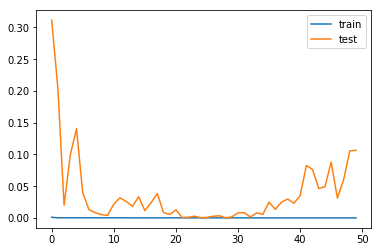

In [56]:
from matplotlib import pyplot

pyplot.plot(training_process.history['loss'], label='train')
pyplot.plot(training_process.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

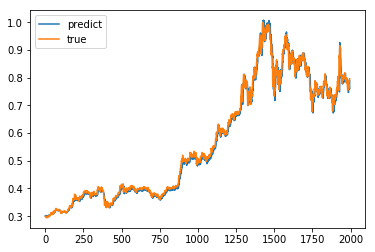

In [57]:
yhat = Model_complete.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

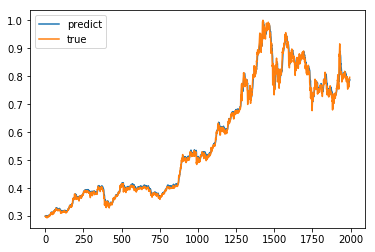

In [159]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [58]:
from math import *

yhat_inverse = scaler.inverse_transform(yhat.reshape(-1,1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 660.549


In [160]:
from math import *

yhat_inverse = scaler.inverse_transform(yhat.reshape(-1,1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 494.510


https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

## shifting 하는거


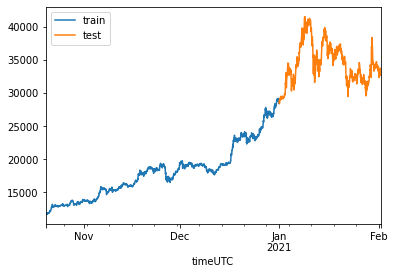

In [18]:
split_date = pd.Timestamp('01-01-2021')
# 2021/1/1 까지의 데이터를 트레이닝셋.
# 그 이후 데이터를 테스트셋으로 한다.

train = data1.loc[:split_date]
test = data1.loc[split_date:]
# Feature는 Unadjusted 한 개

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])





In [19]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc




array([[0.0019861 ],
       [0.00317089],
       [0.00241308],
       ...,
       [0.96353706],
       [0.95444165],
       [0.97917115]])

In [20]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()




,Scaled
timeUTC,
2020-10-20 05:00:00,0.001986
2020-10-20 06:00:00,0.003171
2020-10-20 07:00:00,0.002413
2020-10-20 08:00:00,0.003235
2020-10-20 09:00:00,0.001791


In [21]:
for s in range(1, 3):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

train_sc_df.head(7)


,Scaled,shift_1,shift_2
timeUTC,,,
2020-10-20 05:00:00,0.001986,NaN,NaN
2020-10-20 06:00:00,0.003171,0.001986,NaN
2020-10-20 07:00:00,0.002413,0.003171,0.001986
2020-10-20 08:00:00,0.003235,0.002413,0.003171
2020-10-20 09:00:00,0.001791,0.003235,0.002413
2020-10-20 10:00:00,0.000000,0.001791,0.003235
2020-10-20 11:00:00,0.001553,0.000000,0.001791


In [22]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]




In [23]:
X_train.head()

,shift_1,shift_2
timeUTC,,
2020-10-20 07:00:00,0.003171,0.001986
2020-10-20 08:00:00,0.002413,0.003171
2020-10-20 09:00:00,0.003235,0.002413
2020-10-20 10:00:00,0.001791,0.003235
2020-10-20 11:00:00,0.000000,0.001791


In [24]:
y_train.head()

,Scaled
timeUTC,
2020-10-20 07:00:00,0.002413
2020-10-20 08:00:00,0.003235
2020-10-20 09:00:00,0.001791
2020-10-20 10:00:00,0.000000
2020-10-20 11:00:00,0.001553


In [25]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)




(1746, 2)
[[0.00317089 0.0019861 ]
 [0.00241308 0.00317089]
 [0.00323499 0.00241308]
 ...
 [0.97030869 0.98571841]
 [0.96353706 0.97030869]
 [0.95444165 0.96353706]]
(1746, 1)
[[0.00241308]
 [0.00323499]
 [0.0017915 ]
 ...
 [0.96353706]
 [0.95444165]
 [0.97917115]]


In [26]:
X_train_t = X_train.reshape(X_train.shape[0], 2, 1) 
X_test_t = X_test.reshape(X_test.shape[0], 2, 1)


In [27]:
print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)



최종 DATA
(1746, 2, 1)
[[[0.00317089]
  [0.0019861 ]]

 [[0.00241308]
  [0.00317089]]

 [[0.00323499]
  [0.00241308]]

 ...

 [[0.97030869]
  [0.98571841]]

 [[0.96353706]
  [0.97030869]]

 [[0.95444165]
  [0.96353706]]]
[[0.00241308]
 [0.00323499]
 [0.0017915 ]
 ...
 [0.96353706]
 [0.95444165]
 [0.97917115]]


In [319]:

import tensorflow.keras.backend as K 
from tensorflow.keras.callbacks import EarlyStopping 
K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(100, input_shape=(X_train_t.shape[1], X_train_t.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [320]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=20,
          batch_size=16, verbose=1)




Epoch 1/20
110/110 [==============================] - 0s 1ms/step - loss: 0.0359
Epoch 2/20
110/110 [==============================] - 0s 1ms/step - loss: 6.2887e-04
Epoch 3/20
110/110 [==============================] - 0s 1ms/step - loss: 2.1661e-04
Epoch 4/20
110/110 [==============================] - 0s 1ms/step - loss: 1.7869e-04
Epoch 5/20
110/110 [==============================] - 0s 1ms/step - loss: 1.4293e-04
Epoch 6/20
110/110 [==============================] - 0s 1ms/step - loss: 1.2872e-04
Epoch 7/20
110/110 [==============================] - 0s 1ms/step - loss: 9.8637e-05
Epoch 8/20
110/110 [==============================] - 0s 1ms/step - loss: 8.3698e-05
Epoch 9/20
110/110 [==============================] - 0s 1ms/step - loss: 7.6040e-05
Epoch 10/20
110/110 [==============================] - 0s 1ms/step - loss: 7.5892e-05
Epoch 11/20
110/110 [==============================] - 0s 1ms/step - loss: 7.4798e-05
Epoch 12/20
110/110 [==============================] - 0s 1ms/step 

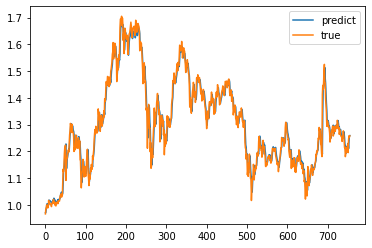

In [321]:

y_pred = model.predict(X_test_t)
pyplot.plot(y_pred, label='predict')
pyplot.plot(y_test, label='true')
pyplot.legend()
pyplot.show()

In [328]:
yhat.shape

(756, 1)

In [329]:
testY.shape

(500,)

In [327]:
#history = model.fit(X_train_t, y_train, epochs=30, batch_size=10, validation_data=(X_test_t, y_test), verbose=0, shuffle=False)
yhat = model.predict(X_test_t)
#yhat_inverse = yhat.ravel()
#testY_inverse = y_test.ravel()
scaler2 = MinMaxScaler()
scaler2.min_, scaler2.scale_ = scaler.min_[0], scaler.scale_[0]

yhat_inverse = scaler.inverse_transform(yhat)
testY_inverse = scaler.inverse_transform(testY)
rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print ("Done")
print ('Test RMSE: %.3f' % rmse_sent)

ValueError: non-broadcastable output operand with shape (756,1) doesn't match the broadcast shape (756,5)

In [654]:
testY_inverse.tolist()

[0.9667460117283561,
 0.9846662102636626,
 0.9864486591660434,
 0.999857561727005,
 0.9900084899966671,
 0.9975278796177024,
 0.9887738372983345,
 0.9930807653157739,
 1.0165487375352438,
 1.003704521092124,
 1.0095495572590596,
 1.005676700026123,
 1.003131953014512,
 1.0024681794024124,
 0.9987985641321285,
 0.9935925297037284,
 1.0050894940232227,
 1.0062318151928151,
 1.0114384126183422,
 1.0072857458135531,
 1.0202600145928855,
 1.0123611649086142,
 1.0044020745318116,
 1.010961554052228,
 0.9983318395142909,
 0.9976320340860981,
 0.9961626115860304,
 1.007211993189987,
 1.0039623737760444,
 1.0093778431354887,
 1.01222491960401,
 1.004485398106528,
 1.0148839550322934,
 1.0125964977074755,
 1.013957261762136,
 1.0143750056299714,
 1.0273661643230971,
 1.0342217803320333,
 1.0368695558177872,
 1.0404378316053076,
 1.0283992640501562,
 1.0318194715934168,
 1.0361725653752263,
 1.0831321556934772,
 1.131379883437075,
 1.121758262545828,
 1.146191774837181,
 1.1884706070460216,
 1.21

In [651]:
yhat_inverse.reshape(-1,1)

array([[0.41064307],
       [0.41071   ],
       [0.41054648],
       [0.4120195 ],
       [0.4077616 ],
       [0.40563706],
       [0.4101848 ],
       [0.41610965],
       [0.41439262],
       [0.4079402 ],
       [0.40789166],
       [0.40882316],
       [0.4137763 ],
       [0.41385075],
       [0.41248858],
       [0.4118966 ],
       [0.40847337],
       [0.39506638],
       [0.39874795],
       [0.4012557 ],
       [0.39736018],
       [0.40014467],
       [0.39561188],
       [0.38865435],
       [0.38273656],
       [0.3722981 ],
       [0.3787802 ],
       [0.38250872],
       [0.38676453],
       [0.3841249 ],
       [0.37313148],
       [0.37391818],
       [0.3642933 ],
       [0.35388842],
       [0.35559326],
       [0.34911725],
       [0.3273221 ],
       [0.34357464],
       [0.35475928],
       [0.35790998],
       [0.35390988],
       [0.34108543],
       [0.34153304],
       [0.3248486 ],
       [0.3314326 ],
       [0.31332725],
       [0.3146956 ],
       [0.326

In [655]:
mean_squared_error(testY_inverse.tolist(), yhat_inverse.tolist())

ValueError: Found input variables with inconsistent numbers of samples: [718, 500]

In [645]:
testY_inverse

array([0.96674601, 0.98466621, 0.98644866, 0.99985756, 0.99000849,
       0.99752788, 0.98877384, 0.99308077, 1.01654874, 1.00370452,
       1.00954956, 1.0056767 , 1.00313195, 1.00246818, 0.99879856,
       0.99359253, 1.00508949, 1.00623182, 1.01143841, 1.00728575,
       1.02026001, 1.01236116, 1.00440207, 1.01096155, 0.99833184,
       0.99763203, 0.99616261, 1.00721199, 1.00396237, 1.00937784,
       1.01222492, 1.0044854 , 1.01488396, 1.0125965 , 1.01395726,
       1.01437501, 1.02736616, 1.03422178, 1.03686956, 1.04043783,
       1.02839926, 1.03181947, 1.03617257, 1.08313216, 1.13137988,
       1.12175826, 1.14619177, 1.18847061, 1.21089422, 1.21563015,
       1.21982955, 1.08993035, 1.14312119, 1.16890702, 1.17069172,
       1.18664424, 1.19338613, 1.20218409, 1.19397784, 1.22976645,
       1.25731221, 1.27111746, 1.29947957, 1.29334177, 1.28391945,
       1.26610678, 1.29675522, 1.27872693, 1.26727275, 1.26609778,
       1.24898998, 1.19633399, 1.21027549, 1.20328475, 1.20267

In [646]:
yhat_inverse

array([0.41064307, 0.41071   , 0.41054648, 0.4120195 , 0.4077616 ,
       0.40563706, 0.4101848 , 0.41610965, 0.41439262, 0.4079402 ,
       0.40789166, 0.40882316, 0.4137763 , 0.41385075, 0.41248858,
       0.4118966 , 0.40847337, 0.39506638, 0.39874795, 0.4012557 ,
       0.39736018, 0.40014467, 0.39561188, 0.38865435, 0.38273656,
       0.3722981 , 0.3787802 , 0.38250872, 0.38676453, 0.3841249 ,
       0.37313148, 0.37391818, 0.3642933 , 0.35388842, 0.35559326,
       0.34911725, 0.3273221 , 0.34357464, 0.35475928, 0.35790998,
       0.35390988, 0.34108543, 0.34153304, 0.3248486 , 0.3314326 ,
       0.31332725, 0.3146956 , 0.3267614 , 0.32442212, 0.32068732,
       0.33280623, 0.33991736, 0.34418643, 0.35536608, 0.34958336,
       0.34241676, 0.34384552, 0.34997076, 0.3533289 , 0.35936403,
       0.36105025, 0.36549416, 0.35847846, 0.3598355 , 0.35083827,
       0.35416672, 0.3502341 , 0.33180442, 0.33312112, 0.3376574 ,
       0.3501552 , 0.34999377, 0.35013303, 0.34669927, 0.34265

In [15]:
train_X.shape


(2003, 1, 2)

In [28]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_t.shape[1], X_train_t.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.summary(1)

#unsucessful tested layers:
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(GRU(64, dropout=0.1, recurrent_dropout=0.1))

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling1d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](max_pooling1d/ExpandDims)' with input shapes: [?,1,1,64].